In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/data1/parker/LO_data/grids/cas7/grid.nc')

In [3]:
ctd2013 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2013.p')
ctd2014 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2014.p')
ctd2015 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2015.p')
ctd2016 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2016.p')
ctd2017 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2017.p')
ctd2018 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2018.p')
ctd2019 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2019.p')


In [4]:
bot2013 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2013.p')
bot2014 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2014.p')
bot2015 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2015.p')
bot2016 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2016.p')
bot2017 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2017.p')
bot2018 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2018.p')
bot2019 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2019.p')


In [5]:
obs = pd.concat([bot2013['obs'], bot2014['obs'], bot2015['obs'], bot2016['obs'], bot2017['obs'], bot2018['obs'], bot2019['obs']], ignore_index=True)
obs.name = 'bottle' # so that we can differentiate between bottle and ctd casts from dfo just in case
obs = pd.concat([obs,ctd2013['obs'], ctd2014['obs'], ctd2015['obs'], ctd2016['obs'], ctd2017['obs'], ctd2018['obs'], ctd2019['obs']], ignore_index=True)
obs.head()

,cid,lon,lat,time,z,SA,CT,DO (uM),NO3 (uM),Chl (mg m-3),name,cruise,source,NO2 (uM),NH4 (uM),PO4 (uM),SiO4 (uM),TA (uM),DIC (uM)
0,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-4.858567,29.526436,8.481087,217.480499,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-25.084826,29.931217,8.744595,194.705338,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-49.770050,30.161832,8.232655,199.617615,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-99.627083,31.185733,9.074455,7.145150,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-148.778397,31.455940,9.045912,5.805434,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# remove all unreasonable DO values, based on calculated max DO
obs.loc[obs['DO (uM)'] > 475, 'DO (uM)'] = pd.NA

# remove negative NO3 and Chl
obs.loc[obs['NO3 (uM)'] < 0, 'NO3 (uM)'] = pd.NA
obs.loc[obs['Chl (mg m-3)'] < 0, 'Chl (mg m-3)'] = pd.NA

# remove unresonable salinities
obs.loc[obs['SA'] > 40, 'SA'] = pd.NA


In [7]:
# calculate N*
# N∗=(N−16×P)+2.9

obs['Nstar'] = (obs['NO3 (uM)']+obs['NO3 (uM)'])-(16*obs['PO4 (uM)'])+2.9

Text(0, 0.5, 'Monthly count')

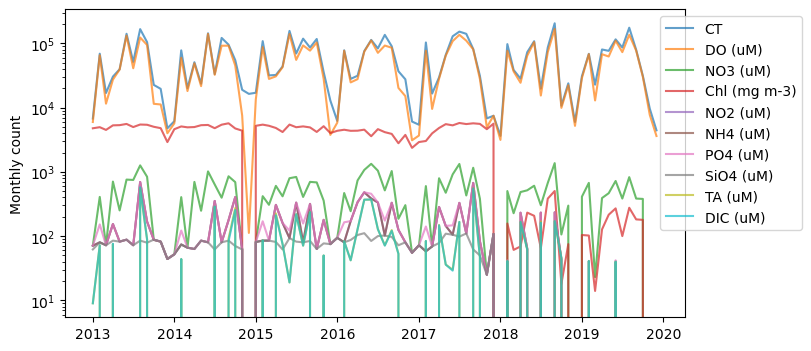

In [8]:
# lets see how the count of data changes with time, seperated by what was measured
# Extract both month and year from the 'time' column
obs['year_month'] = obs['time'].dt.to_period('M')  # This creates a Period object 'YYYY-MM'
obs['year_month'] = obs['year_month'].dt.to_timestamp()

# Columns to count non-NaN entries
columns_to_count = [
    'SA', 'CT', 'DO (uM)', 'NO3 (uM)', 'Chl (mg m-3)', 'NO2 (uM)', 
    'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)', 'DIC (uM)'
]

# Group by 'year_month' and count non-NaN entries for each column
monthly_counts = obs.groupby('year_month')[columns_to_count].count()

# plot
fig, ax = plt.subplots(1,1,figsize=[8,4])

for var in monthly_counts.columns[1:]:
    ax.plot(monthly_counts.index, monthly_counts[var], label=var,alpha=0.7)

ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.2, 1.0))
ax.set_ylabel('Monthly count')


In [9]:
obs['month']=[obs.time[i].month for i in obs.index]

## remove Salish Sea and Johnstone Strait points (too many of the clusters delineating within there)

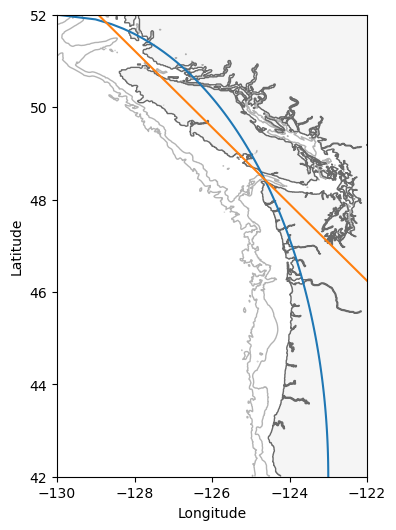

In [10]:
grid = xr.open_dataset('/data1/parker/LO_data/grids/cas6/grid.nc')

fig, ax = plt.subplots(1,1,figsize=(4, 6))

ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000], colors='dimgray', alpha=0.5)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([42,52])
ax.set_xlim([-130,-122])

# salish sea cuttoff
y=np.linspace(42,52,100)
x = np.sqrt((1-((y-42)**2)/(10**2))*(7**2))-130
ax.plot(x,y)

# salish sea cuttoff?
x = np.linspace(-130,-122,10)
m = -0.83
b = 48.4-(-124.6)*m
y = m*x+b
ax.plot(x,y)

In [11]:
# ny = 49.2
# sy = 47.4
# d = 2000

# from evaluations code where i separate into regions
# ind = np.where((obs.lon > np.sqrt((1-(((obs.lat-42)**2)/(10**2)))*(7**2))-130) & (obs.lat < 51))
# 
# using new dlineation (orange line) 
ind = np.where(obs.lon > (obs.lat-b)/m) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [12]:
    def cluster(keys, n, winter):

        # Drop rows with NaN values in the 'key' column
        df_clean = obs.dropna(subset=keys)

        if winter==True:
            df_clean = df_clean[(df_clean.month >= 11) | (df_clean.month <= 2)]
        else:
            df_clean = df_clean[(df_clean.month >= 5) & (df_clean.month <= 8)]

        # Selecting the properties to cluster
        X = df_clean[keys].values

        # Normalizing the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Applying K-means clustering
        kmeans = KMeans(n_clusters=N, random_state=0).fit(X_scaled)

        # Assign the cluster labels back to the DataFrame
        df_clean['Cluster'] = kmeans.labels_

        return df_clean

    def cluster_plot_multi(df_clean, keys):
        for key in keys:
            # Plotting clusters
            plt.figure(figsize=(6,4)) 
            ax0 = plt.subplot(131)
            ax1 = plt.subplot(132, projection='3d')

            for cluster in range(len(df_clean['Cluster'].unique())):
                cluster_data = df_clean[df_clean['Cluster'] == cluster]
                ax0.scatter(cluster_data[key], cluster_data['z'], s=3, label=f'Cluster {cluster}')
                ax1.scatter(cluster_data['lon'], cluster_data['lat'], cluster_data['z'], zdir='z', s=2, alpha=0.2, depthshade=True)

            ax0.set_ylabel('Depth (m)')
            ax0.set_xlabel(key)
            ax0.set_title(key+' Clusters')
            ax0.legend()
            ax0.set_ylim([-4000,0])

            plt.tight_layout()

    def ind_cluster_plots(data, n, ax, colour):
        
        
        cluster_data = data[data['Cluster'] == n]
        ax.scatter(cluster_data['lon'], cluster_data['lat'], color=colour, alpha=0.8, s=3, label=f'Cluster {n}')

        ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
        ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
        ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000, 2000], colors='dimgray', alpha=0.5)
        ax.set_ylabel('Latitude')
        ax.set_xlabel('Longitude')
        ax.set_ylim([42,52])
        ax.set_xlim([-130,-122])

        title = 'cluster '+str(n)+': '+str(len(cluster_data))
        ax.set_title(n)

        plt.tight_layout()

In [13]:
colours = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

In [14]:
N=4

## clustering multiple tracers at a time
*StandardScalar()* subtracts the mean of each feature from the respective feature data points, and then divides by the standard deviation of that feature. This transforms each feature to have a mean (average) of zero and a standard deviation of one.

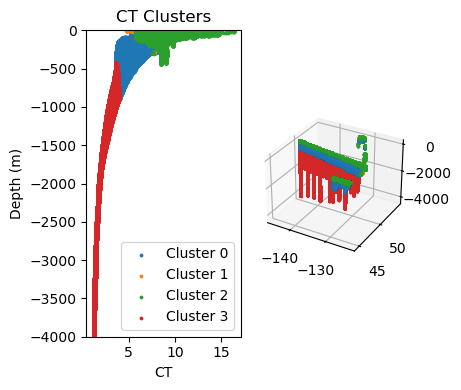

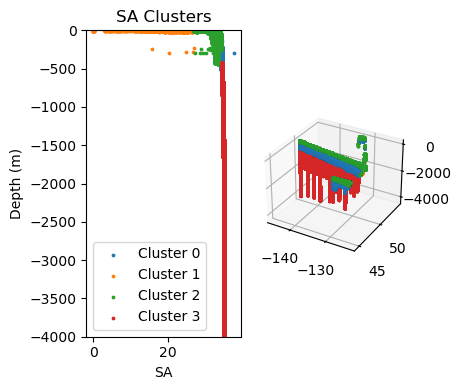

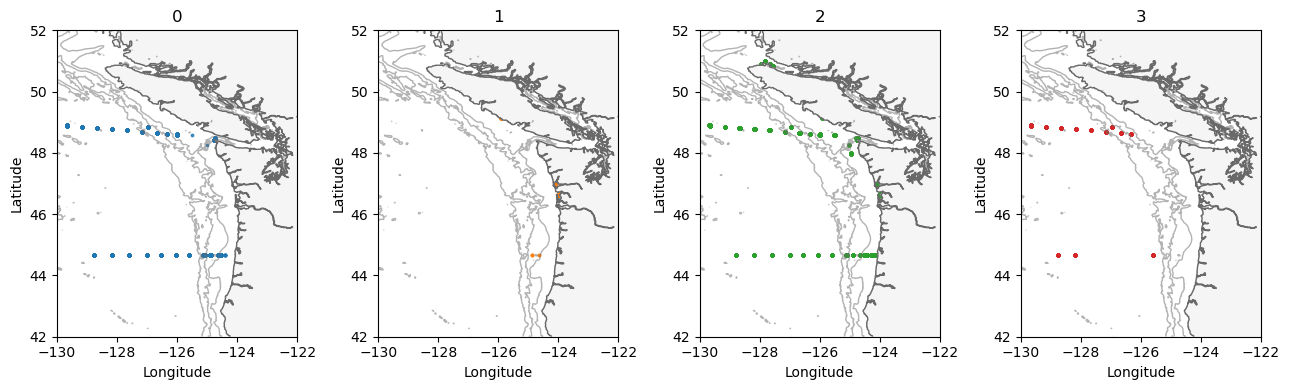

In [15]:
# winter CT and SA
TScluster = cluster(["CT",'SA'], N, True)
cluster_plot_multi(TScluster, ["CT",'SA'])

fig, ax = plt.subplots(1,N,figsize=[13,4])
for n in range(N):
    ind_cluster_plots(TScluster, n, ax[n], colours[n])

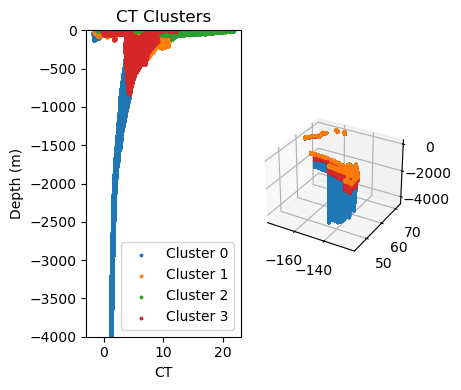

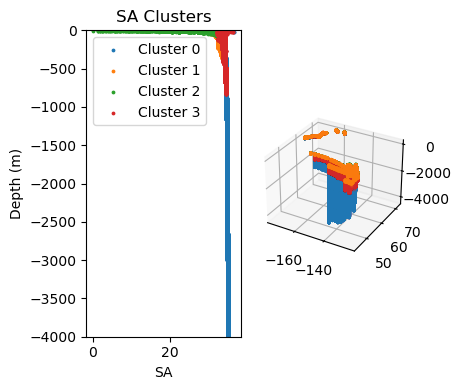

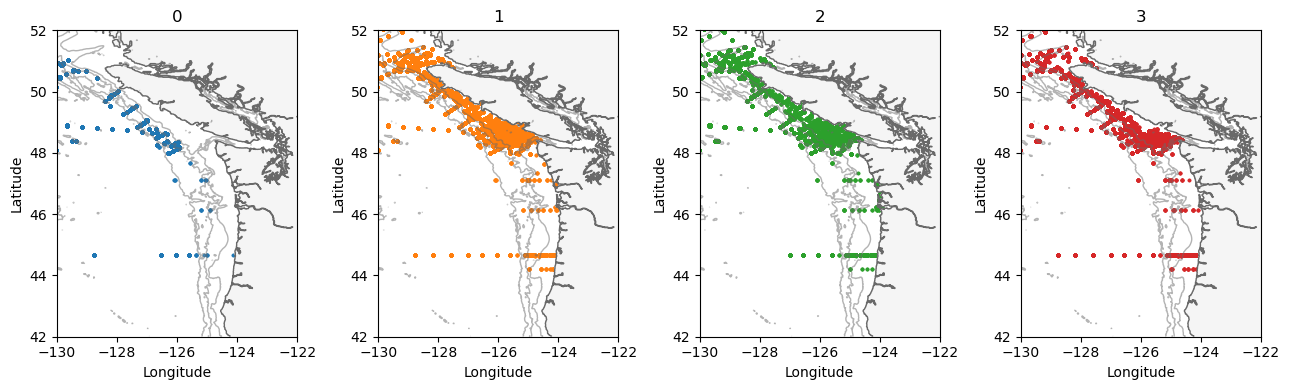

In [19]:
# summer CT and SA
TScluster = cluster(["CT",'SA'], N, False)
cluster_plot_multi(TScluster, ["CT",'SA'])

fig, ax = plt.subplots(1,N,figsize=[13,4])
for n in range(N):
    ind_cluster_plots(TScluster, n, ax[n], colours[n])

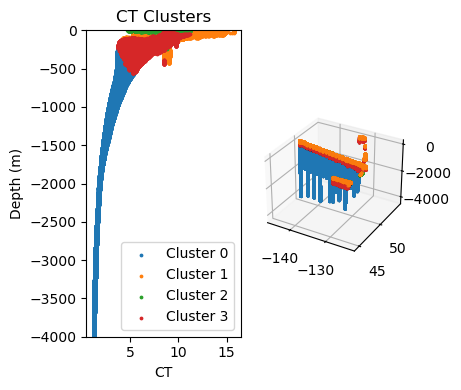

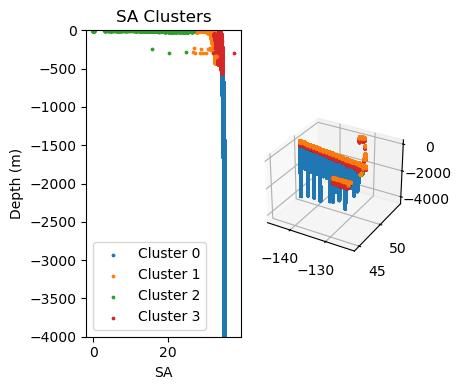

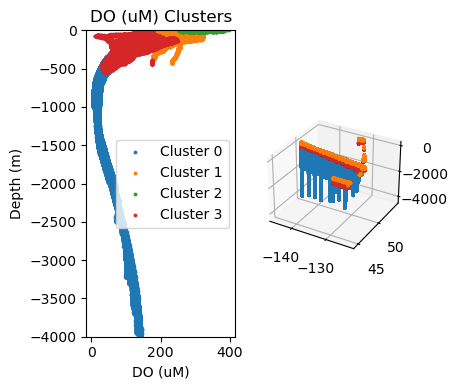

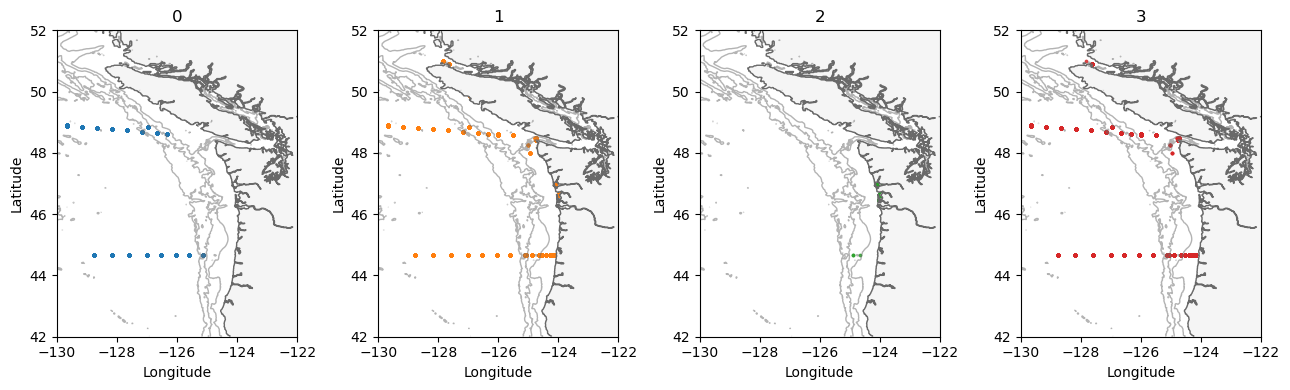

In [20]:
# winter CT and SA and DO
TScluster = cluster(["CT",'SA','DO (uM)'], N, True)
cluster_plot_multi(TScluster, ["CT",'SA','DO (uM)'])

fig, ax = plt.subplots(1,N,figsize=[13,4])
for n in range(N):
    ind_cluster_plots(TScluster, n, ax[n], colours[n])

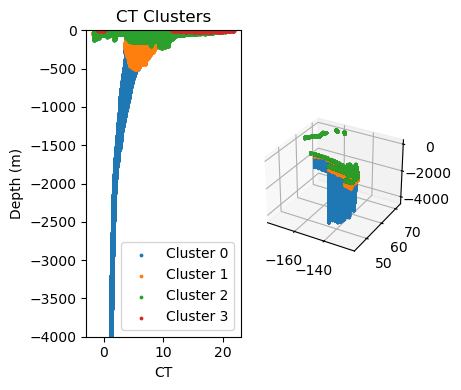

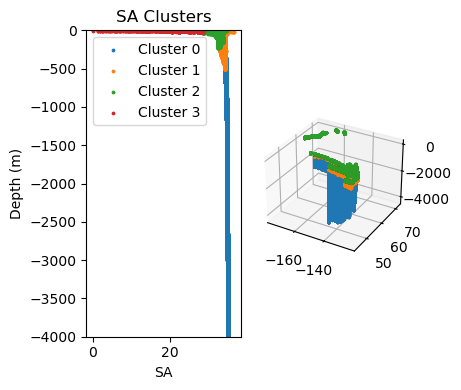

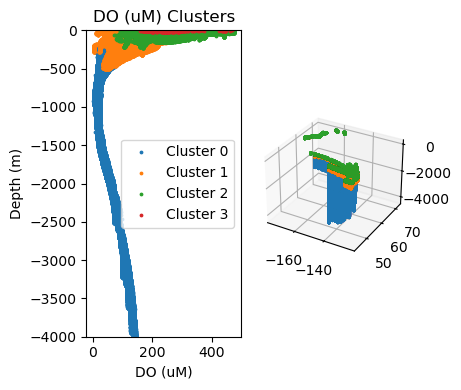

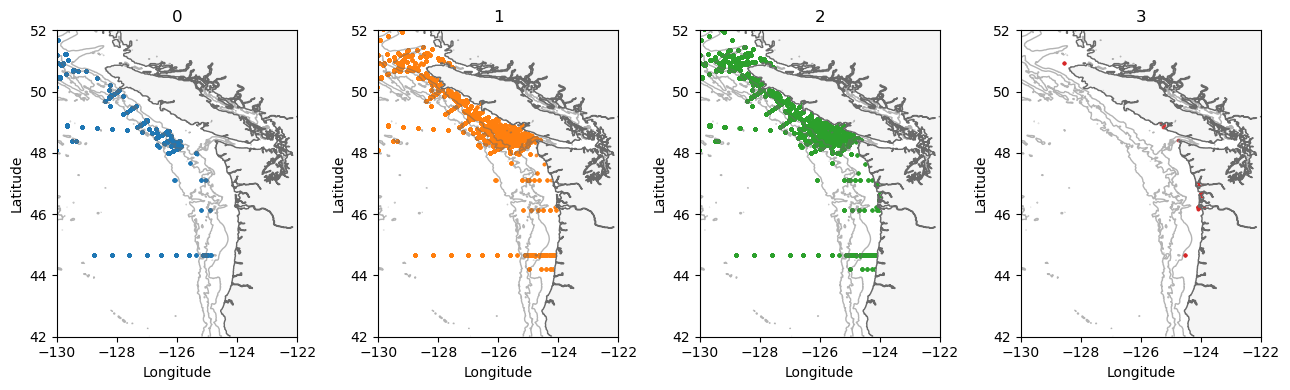

In [21]:
# summer CT and SA and DO
TScluster = cluster(["CT",'SA','DO (uM)'], N, False)
cluster_plot_multi(TScluster, ["CT",'SA','DO (uM)'])

fig, ax = plt.subplots(1,N,figsize=[13,4])
for n in range(N):
    ind_cluster_plots(TScluster, n, ax[n], colours[n])

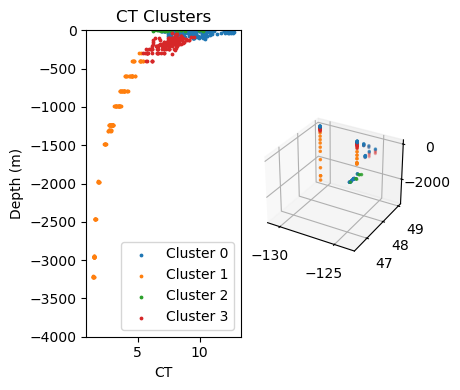

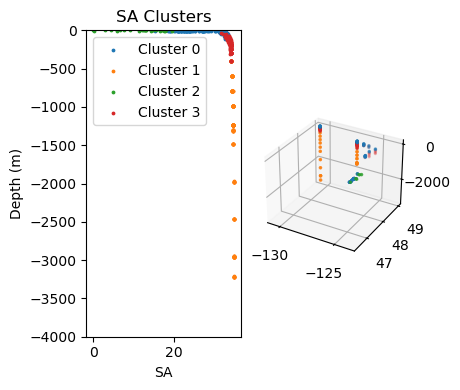

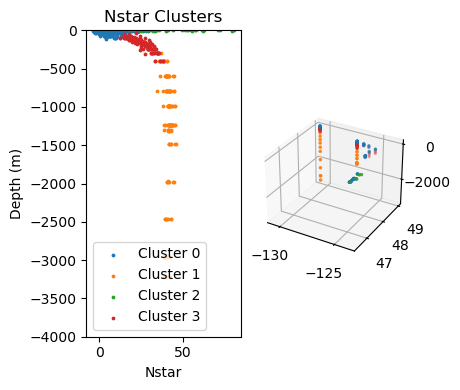

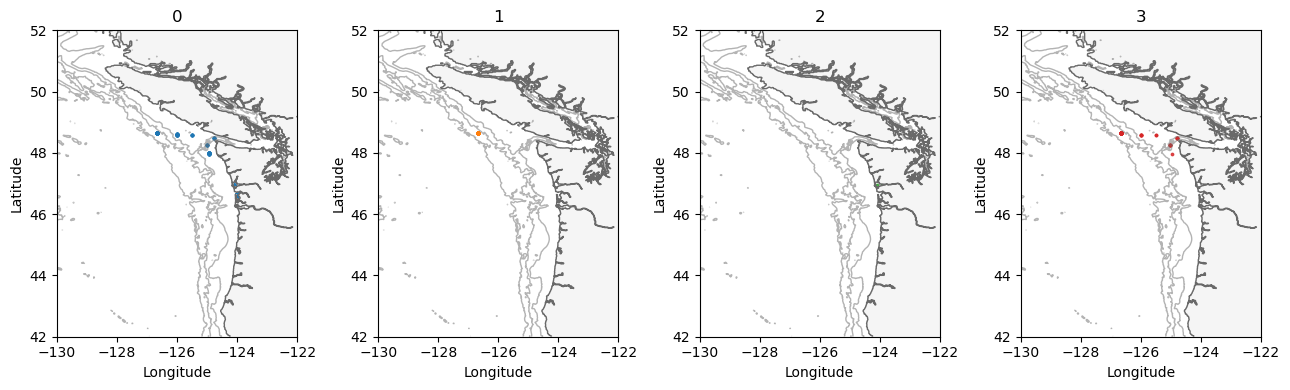

In [18]:
# winter CT and SA and DO
TScluster = cluster(["CT",'SA','Nstar'], N, True)
cluster_plot_multi(TScluster, ["CT",'SA','Nstar'])

fig, ax = plt.subplots(1,N,figsize=[13,4])
for n in range(N):
    ind_cluster_plots(TScluster, n, ax[n], colours[n])

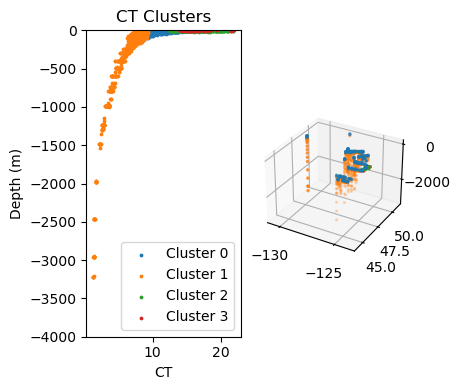

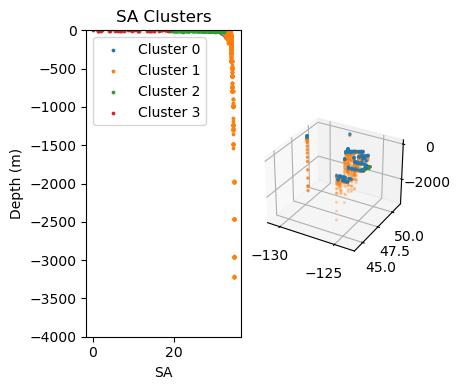

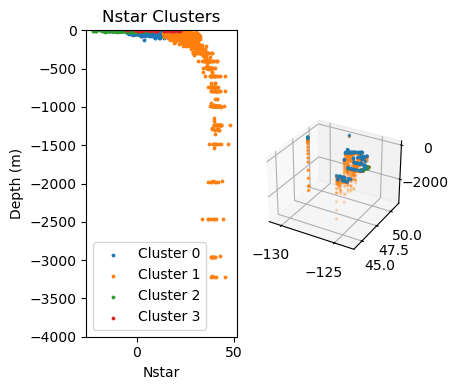

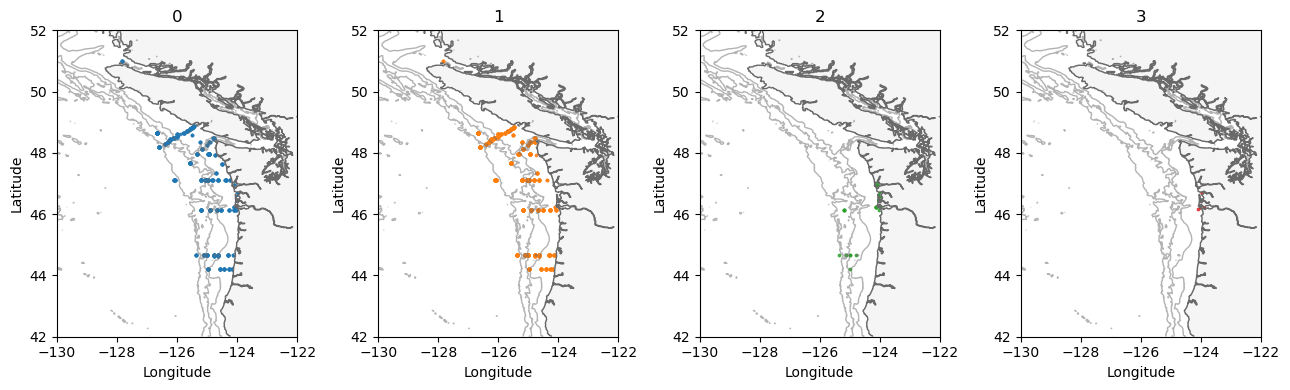

In [17]:
# summer CT and SA and DO
TScluster = cluster(["CT",'SA','Nstar'], N, False)
cluster_plot_multi(TScluster, ["CT",'SA','Nstar'])

fig, ax = plt.subplots(1,N,figsize=[13,4])
for n in range(N):
    ind_cluster_plots(TScluster, n, ax[n], colours[n])